# 8.2. Training a Convnet from scratch on a small dataset
- The dataset contains 25000 images of dogs and cats (12,500 for each class). We will create a new dataset containing 3 subsets:
    - Training set with 1000 samples of each class.
    - Validation set with 500 samples of each class.
    - Test set with 1000 samples of each class.
- Having more dataset will make the problem easier also cost a lot of computational power.

In [1]:
!rm -rf convnet_from_scratch.keras train cats_vs_dogs_small test1

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
# import libraries
import os
import zipfile
import pandas as pd
import os, shutil, pathlib
import matplotlib.pyplot as plt

# import TF
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

## 8.2.1. Download Dataset

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [4]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    z.close()
    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
    z.close()

In [5]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  test1  train


### Copy images to training, validation, and test directories

In [6]:
# set paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [7]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [8]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [9]:
!ls cats_vs_dogs_small/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
test  train  validation


## 8.2.2. Build model
- We will still use the architecture Convnet as MNIST but we will add Conv2D and MaxPooling2D to further reduce the feature maps in the Flatten layer. Here, the size of the feature maps decrease from 180x180 to 7x7while the depth of the feature map increase from 32 to 256. As we are doing binary classification, we will use `sigmoid` activation function.
- We will rescalre the image range from [0, 255] to [0, 1].

In [10]:
# build model
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [12]:
# compile model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## 8.2.3. Data Preprocessing
- We need to process it into tensor.
    - Read picture file.
    - Decode JPEG into RGB grids of pixels.
    - Convert these into floating-point tensors.
    - Resize them to a same size (180x180).
    - Pack them into batches (32 images / batch).
- By using the function `image_dataset_from_directory()` we can get the Dataset object which is an iterator. We can use it in a for loop and it will return the batch of input data and labels. The assumption here is that each folder contains images from one of our class. It will then index the image files in each subdirectory. Finally, it will create and return a `tf.data.Dataset` object configured to each these files, shuffle them, decode them to tensors, resize them to a shared size and pack them into batches.

In [13]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
# check dataset
for data_batch, label_batch in train_dataset:
    print(data_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Model Checkpoint callback
- Save the model after each epoch. This way guarantees that your saved file will always contain the state of the model corresponding to its best performing training epoch, in terms of its performance on the validation data.
- By then, we don't have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file

In [15]:
# set up call backs
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

# train model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 11s 63ms/step - loss: 0.7199 - accuracy: 0.5255 - val_loss: 0.6992 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6843 - accuracy: 0.5860 - val_loss: 0.6854 - val_accuracy: 0.5400
Epoch 3/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6454 - accuracy: 0.6360 - val_loss: 0.6600 - val_accuracy: 0.6030
Epoch 4/30
63/63 [==============================] - 4s 57ms/step - loss: 0.5841 - accuracy: 0.6770 - val_loss: 0.6045 - val_accuracy: 0.6680
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5495 - accuracy: 0.7280 - val_loss: 0.7546 - val_accuracy: 0.6370
Epoch 6/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5065 - accuracy: 0.7445 - val_loss: 0.6413 - val_accuracy: 0.6920
Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 0.4577 - accuracy: 0.7795 - val_loss: 0.6568 - val_accuracy: 0.6800
Epoch 8/30
6

### Display curves of loss and accuracy during training

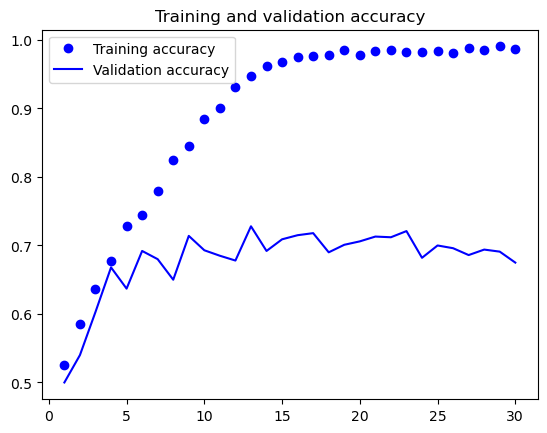

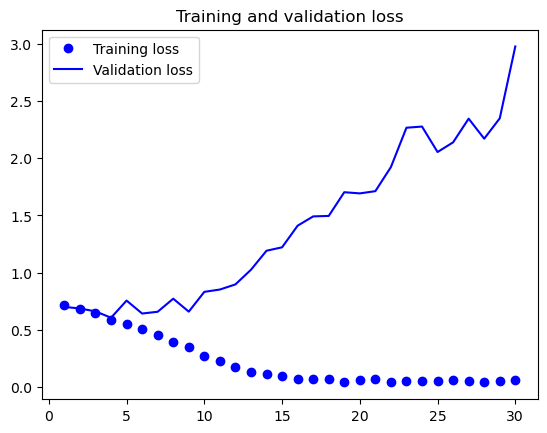

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Note**: the plots are overfit. The training accuracy increases linearly over time till it is 100%, while the validation accuracy is 75% peak. The validation loss stall after 10 epochs while the training loss keep decreasing.

### Evaluate the model on testset

In [17]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.6128 - accuracy: 0.6815
Test accuracy: 0.682


**Note**: now overfit will be our concern. We can keep pushing the limit by using regularization: dropout or weight decay (L2). However, we can also use data augmentation.

## 8.2.4. Data Augmentation
- In our case, since the model is relatively larger than the dataset, aka we don't have enough data. Thus overfit happens. 
- Data augmentation randomly transform the image to a believable-looking images. 
- Goal, at the training time, the model will never see the same exact picture twice. This helps expose the model to more aspects of the data so it can generalize better.

In [18]:
# add data augmenntation layers - to all images
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), 
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### Display some randomly augmented training image

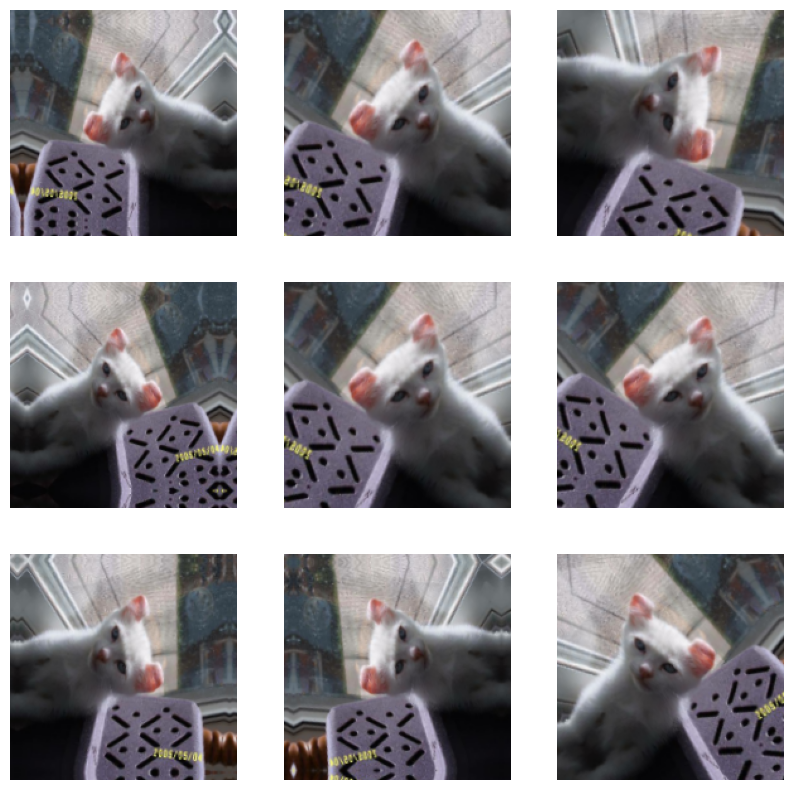

In [19]:
plt.figure(figsize=(10,10))

for images, _ in train_dataset.take(1):  # sample 1 batch, same as "break" the loop
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        
        # display the first image of the batch
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Note**:
- The inputs the model sees are still heavily intercorrelated as they come from a small number of original images. We can't proudce new info; we can only mixing existing info. 
- Similar as Dropout layer, data augmentation layer is inactive during calls of predict() or evaluate().

In [20]:
# build model
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [22]:
# compile model
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [23]:
# set up call backs
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

# train model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 7s 90ms/step - loss: 0.6990 - accuracy: 0.5080 - val_loss: 0.6920 - val_accuracy: 0.5280
Epoch 2/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6922 - accuracy: 0.5435 - val_loss: 0.6859 - val_accuracy: 0.5360
Epoch 3/100
63/63 [==============================] - 6s 81ms/step - loss: 0.6862 - accuracy: 0.5555 - val_loss: 0.6708 - val_accuracy: 0.5740
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6804 - accuracy: 0.5845 - val_loss: 0.6567 - val_accuracy: 0.6240
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6534 - accuracy: 0.6260 - val_loss: 0.6779 - val_accuracy: 0.5900
Epoch 6/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6424 - accuracy: 0.6350 - val_loss: 0.6494 - val_accuracy: 0.6010
Epoch 7/100
63/63 [==============================] - 5s 81ms/step - loss: 0.6228 - accuracy: 0.6535 - val_loss: 0.5970 - val_accuracy: 0.6800
Epoch 

**Note**: Thanks for data augmentation and dropout, the model overfit much later. This means that the validation loss and accuracy curves are closer to the training ones at a lower and higher rate respectively. Our model generalized well!

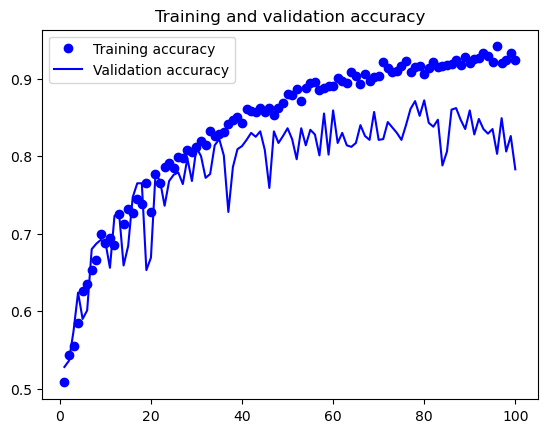

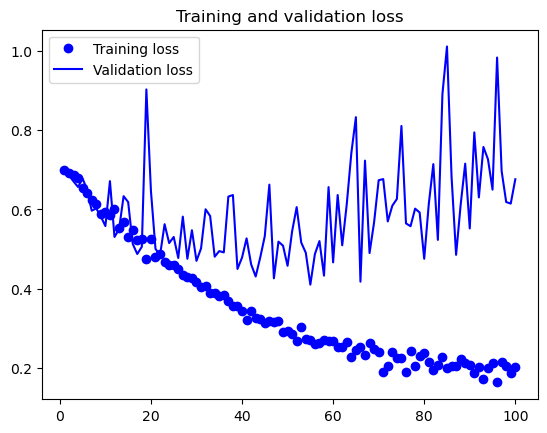

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluate on testset

In [25]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.4405 - accuracy: 0.8275
Test accuracy: 0.827
